#Mount Google Drive and unzip data

In [1]:
#mounting google drive (data are placed in root in zip file)

from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [3]:
!unzip -q "/content/drive/MyDrive/places_64x64_new_correct.zip"

# Import:


*   own developed modules from Google Drive
*   standard libs and 3rd party libs


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/modules')

import os
print(os.listdir('/content/drive/MyDrive/modules'))

from dataread import DataRead

#from custom_losses import generatorMSELossInJoint, generatorAdversarialLoss, discriminatorAdversarialLoss
#from plotter import generateAndPlotImgs, plotImages
from ganscape import GANScape
from train_test import trainNetwork, testNetwork

['__pycache__', 'custom_losses.py', 'network_structure.py', 'ganscape.py', 'train_test.py', 'dataread.py', 'plotter.py']


In [3]:
from __future__ import print_function, division

from keras.layers import Input, Activation, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise, Lambda
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers import Concatenate
from keras.layers.advanced_activations import ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam, Adadelta
from keras import losses, activations
from keras.callbacks import TensorBoard
import keras.backend as K
from keras.utils.vis_utils import plot_model
import scipy
import tensorflow as tf
from IPython.display import clear_output
from datetime import datetime

from PIL import Image  
import PIL  
import matplotlib.pyplot as plt

import os
import time
import numpy as np

#Runnable scripts


*   set parameters
*   build network
*   train & validation
*   test



In [4]:
#init some paramters

#--------------------------------------------------------CAN BE MODIFIED-------------------------------------
epochs = 20
batchSize = 128

generatorDescriber = {
    "earlyPart":{
        "numOfBlocks": 5,
        "filterNums": [64, 128, 128, 256, 256],
        "kernelSizes": [5, 3, 3, 3, 3],
        "strideSizes": [1, 2, 1, 2, 1]
    },
    "midPart":{
        "numOfBlocksWithDilation": 5,
        "filterNum": 256
    },
    "endPart":{
        "numOfBlocks": 4,
        "convolutionType": ["transposed", "normal", "transposed", "normal"],
        "filterNums": [128, 128, 64, 32],
        "kernelSizes": [4, 3, 4, 3],
        "strideSizes": [2, 1, 2, 1]
    }
}

discriminatorDescriber = {
    "global":{
        "numOfBlocks": 5,
        "filterNums": [64, 128, 256, 512, 512],
        "kernelSizes": [5, 5, 5, 5, 5],
        "strideSizes": [2, 2, 2, 2, 2]
    },
    "local":{
        "numOfBlocks": 4,
        "filterNums": [64, 128, 256, 512],
        "kernelSizes": [5, 5, 5, 5],
        "strideSizes": [2, 2, 2, 2]
    },
    "useGlobalAvgPool": False 
}

earlyStopPhases = {
    "phaseTwo": {
        "minForDiscAdv": 0.8,   #if [this value > disc_adv_loss], then skip remained part of phase II
    },
    "phaseThree": {
        "minForDiscAdv": 0.8,  #if [this value > disc_adv_loss] OR
        "maxForGenAdv": 1    #   [this value < gen_adv_loss] then skip remained part of phase III
    }
}

optimizers = {
    "onlyGenMse": Adam(learning_rate=0.01),
    "onlyDisc": Adam(learning_rate=0.001),
    "onlyGenJoint": Adam(learning_rate=0.001)
}
weightsForJointLoss = {
    "mse": 1,
    "adversarial": 1
}


ratios = {           # epoch start --> t = 1
    "phaseOne": 0, #    phase I -->   train generator with mse until: [t <= (phaseOne * total_step_num)]
    "phaseTwo": 0.5  #    phase II -->  train discriminator with adversarial until: [t <= ((phaseOne + phaseTwo) * total_step_num)]
}                    #    phase III --> train generator with joint and discriminator with adversarial until end of epoch

plotImgsDict = {
    "isUsed": True,          
                             # if False then "plot-imgs" feature is not used, so all of other propertys of this object dont matter            
    "saveImgsToFile": True, 
                             # if True then images are saved, if False then images are only shown
    "sleepingTime": 5, 
                             # time of showing images during training - next epoch starts when expired
    "numOfImgs": 6,          
                             # range of accepted value [1, batchSize]
    "numOfImgMapsToSave": 5,

    "figSize": (15,15)       
                             # size of figure
}

numOfBatchesLoadedAtOnce = 10

paths = {
    "data": r"./",
    "logDirForTensorboard": '/content/drive/MyDrive/logs',
    "saveModelDir": '/content/drive/MyDrive/saved_models',
    "saveImgsDirDuringTrain": '/content/drive/MyDrive/saved_imgs_train',
    "saveImgsDirDuringTest": '/content/drive/MyDrive/saved_imgs_test',
}

#--------------------------------------------------------NOT SHOULD BE MODIFIED------------------------------------------------------

numOfAllDataSample = {
    "train": 172703,
    "valid": 20318,
    "test": 10159
}
stepsPerEpoch = {
    "train": numOfAllDataSample["train"] // batchSize,
    "valid": numOfAllDataSample["valid"] // batchSize
}
stepsForTest =numOfAllDataSample["test"] // batchSize

print("Steps per epoch:", stepsPerEpoch)

Steps per epoch: {'train': 1349, 'valid': 158}


In [5]:
#Container-handler for train, valid, test data

#trainData = DataRead(paths["data"],'train', batchSize, numOfBatchesLoadedAtOnce, shuffle = True)
#validData = DataRead(paths["data"],'valid', batchSize, numOfBatchesLoadedAtOnce, shuffle = True)
#testData = DataRead(paths["data"],'test', batchSize, numOfBatchesLoadedAtOnce, shuffle = True)

In [6]:
#create network
net = GANScape(batchSize=batchSize,
               inputImgShape = (64,64,3),
               localDiscInputShape = (28,28,3))

net.buildAndCompile(generatorDescriber = generatorDescriber,
               discriminatorDescriber = discriminatorDescriber,
               optimizers = optimizers,
               weightsForJointLoss = weightsForJointLoss,
               pathForLoadModel = None)

# Runable scripts for:


*   train
*   test



In [10]:
#training
trainLoss, validLoss = trainNetwork(net = net,
                             epochs = epochs,
                             batchSize = batchSize,
                             stepsPerEpoch = stepsPerEpoch,
                             ratios = ratios,
                             numOfBatchesLoadedAtOnce = numOfBatchesLoadedAtOnce,
                             plotImgsDict = plotImgsDict,
                             earlyStopPhases = earlyStopPhases,
                             paths = paths)

Training with 
  -epochs=20,
  -batchSize=128
  -steps for training=1349,
  -steps for validation=158,
  -phase I until step=0,
 -phase II until step=674

---Epoch 1 --- Step 53 --- PHASE II --- disc_adversarial_loss=0.7857258445087617 --- loss condition activated -> PHASE II ENDS NOW'

---Epoch 1 --- Step 675 --- PHASE III --- disc_adversarial_loss=24.171405792236328 --- gen_joint_loss=85.51980590820312 --- gen_mse_loss=0.1803952008485794 --- gen_adversarial_loss=85.33940887451172 --- loss condition activated -> PHASE III ENDS NOW'


---Epoch 1 --- Step 35 --- VALIDATION --- disc_adversarial_loss=2.3833790710994176
---Epoch 1 --- Step 35 --- VALIDATION --- gen_joint_loss=2.4569104398999895 --- gen_mse_loss=0.08680682331323623 --- gen_adversarial_loss=2.37010361126491


KeyboardInterrupt: ignored

Test with 
  -batchSize=128
  -steps=5

Step 5 --- TEST --- mse_loss=0.360736083984375
Step 5        --- TEST --- disc_adversarial_loss=1.2442574977874756
                 --- TEST --- gen_joint_loss=2.057775545120239--- gen_mse_loss=0.360736083984375 --- gen_adversarial_loss=1.6970394611358643


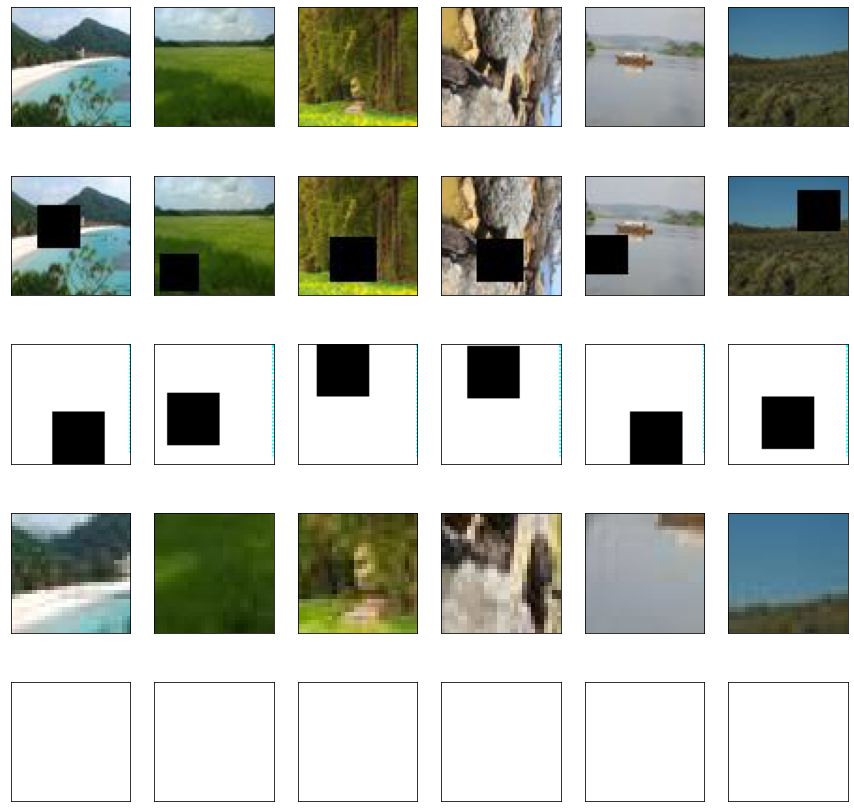

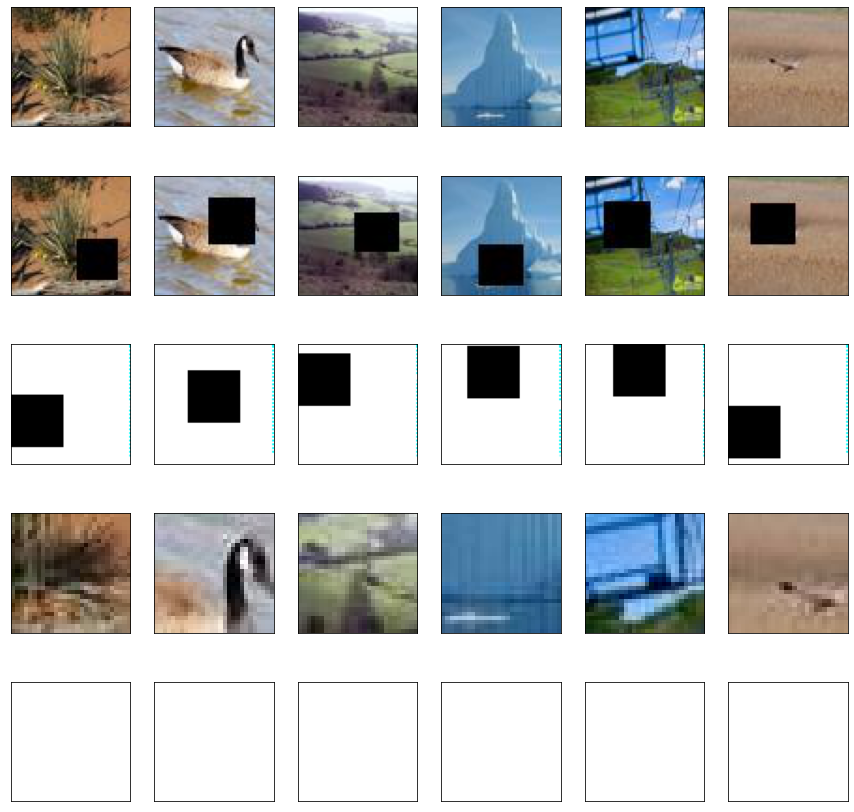

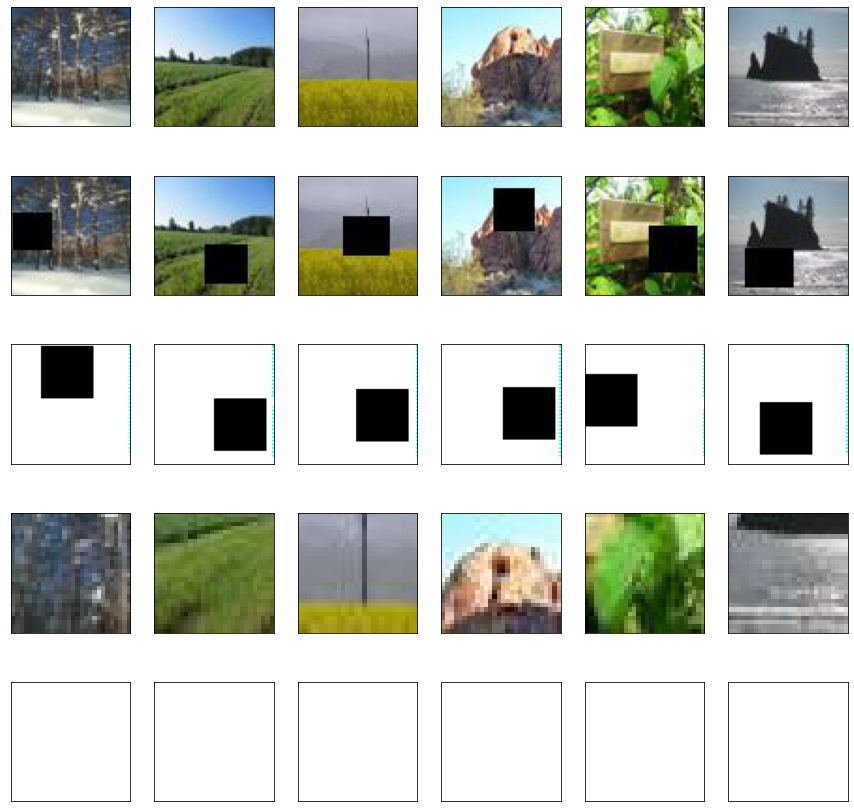

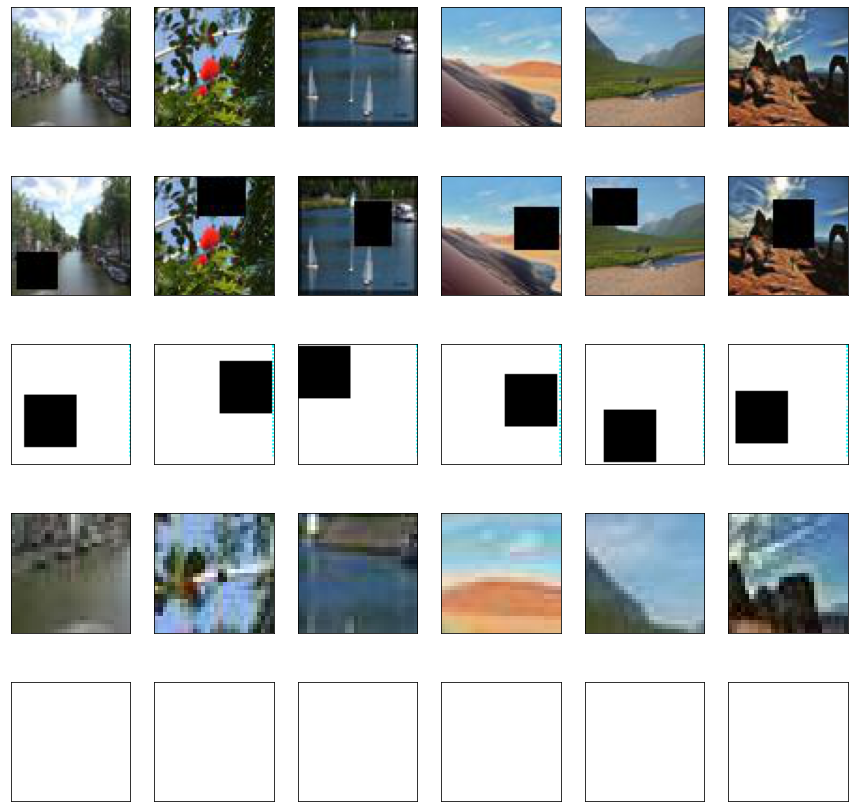

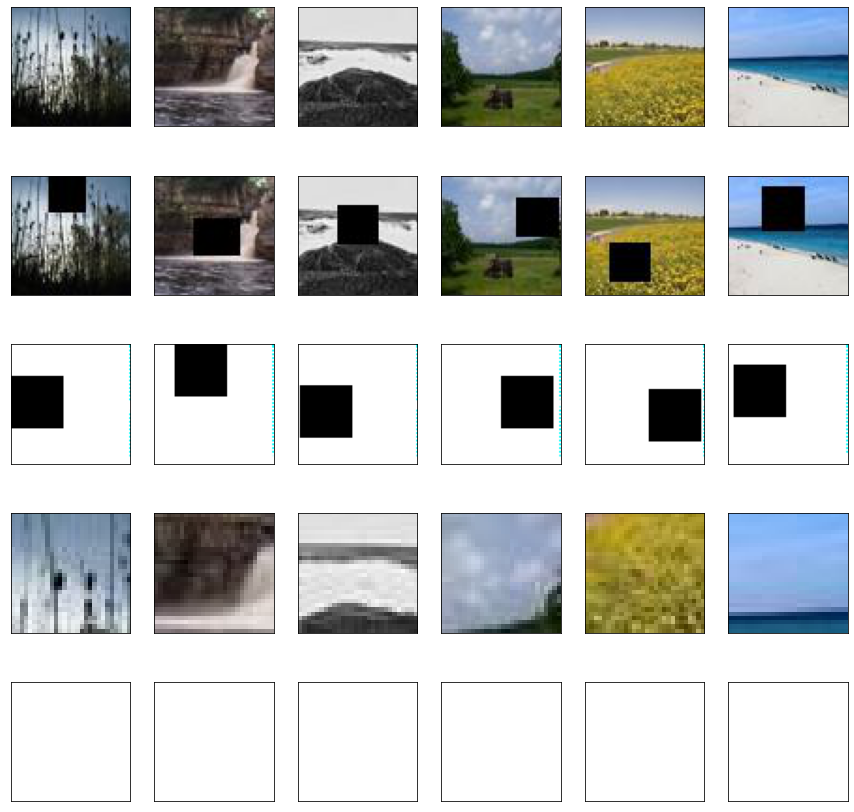

In [ ]:

#test
testLoss = testNetwork(net = net, 
                       batchSize = batchSize, 
                       stepsForTest = stepsForTest, 
                       numOfBatchesLoadedAtOnce = numOfBatchesLoadedAtOnce, 
                       plotImgsDict = plotImgsDict, 
                       paths = paths)

In [ ]:
%load_ext tensorboard

In [ ]:

%tensorboard --logdir /content/drive/MyDrive/logs

In [ ]:
#example for loading a saved model (generator) and make a prediction for a batch of imgs


modelPath = '/content/drive/MyDrive/saved_models/2020_11_30-22_02_46/gen_joint_best/generator'
testData = DataRead(paths["data"], 'test', batchSize, numOfBatchesLoadedAtOnce, shuffle = True)

bestModel = load_model(modelPath)
res = bestModel.predict(x=testData.cropped_images[0],
         batch_size=testData.cropped_images[0].shape[0]
              )
res.shape

10159
10159
10159


(128, 64, 64, 3)